In [1]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
from datasets import load_dataset
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

In [3]:
import pandas as pd

data = pd.read_csv("combined_articles_final.csv")
data

,id,title,link,content,gold_label
0,0,ہم لکھنے والے ایک بے ایمان معاشرہ میں سانس لے ...,https://urdu.arynews.tv/intezar-hussain-urdu-w...,سوچتا ہوں غالب س کتن مختلف زمان جی رہ ہیں شخص ...,entertainment
1,1,’’کیا اُدھر باغ بھی ہے؟‘‘,https://urdu.arynews.tv/lakhnau-nawab-mahalsara/,محمد حسین آزاد ن میر ک بار واقعہ لکھا ہ انھوں...,entertainment
2,2,کچھ زخمی کہہ رہے تھے کہ وہ زندہ ہیں…,https://urdu.arynews.tv/politics-and-politicia...,وطنِ عزیز سیاست دار و مدار رہ ہ جماعت ن کتنا ب...,entertainment
3,3,آگرے والا عبدالکریم اور ملکہ وکٹوریہ,https://urdu.arynews.tv/munshi-abdul-karim-and...,پیار شوہر البرٹ ب حد عزیز ملازم جان بران ک مرن...,entertainment
4,4,"""چچی سیدانی تھیں….”",https://urdu.arynews.tv/aslam-parvez-khaka/,خاکہ نگاری اردو مقبول صنف رہی ہ زیادہ تر اہلِ ...,entertainment
...,...,...,...,...,...
1482,1482,حماس کی جانب سے رہا کی گئی اسرائیلی لڑکی نے من...,https://jang.com.pk/news/1415862,حماس جانب س جان والی اسرایلی نوجوان لڑکی ن منگ...,world
1483,1483,روسی صدر پیوٹن کی انجیلا مرکل کو کتے سے ڈرانے ...,https://jang.com.pk/news/1415855,روس ک صدر ولادیمیر پیوٹن ن سابق جرمن چانسلر ان...,world
1484,1484,چین میں دنیا کا سب سے بڑا سونے کا ذخیرہ دریافت,https://jang.com.pk/news/1415840,دنیا س بڑا سون ذخیرہ چین دریافت ہ غیر ملکی میڈ...,world
1485,1485,یوکرین کو جوہری ہتھیار ملے تو تمام فوجی وسائل ...,https://jang.com.pk/news/1415837,روس ک صدر ولادیمیر پیوٹن ن ہ یوکرین جوہری ہتھی...,world


In [5]:
stopwords = {
    'اور', 'ایک', 'کو', 'ہے', 'میں', 'کی', 'سے', 'پر', 'ہو', 'یہ', 'کا', 'اس', 'کہ', 'کر', 'تھا', 'تھی', 'تھے', 
    'لیے', 'بھی', 'نے', 'جو', 'ہوا', 'وہ', 'کیا', 'جا', 'نہ', 'تو', 'یا', 'کرنے', 'گیا', 'کر', 'دیا', 
    'لیکن', 'بہت', 'آپ', 'ہم', 'سب', 'کچھ', 'اپنے', 'ان', 'کردی', 'اگر', 'ہوتی', 'اب', 'مجھے', 'اسی', 'جس', 'اسے', 
    'اپنی', 'کسی', 'ہوتا', 'انہوں', 'تھیں', 'کہا', 'جب', 'اُس', 'کل', 'کوئی', 'ہوتے', 'تم', 'کس', 'رہا', 'کن', 'ایسے', 
    'جاتا', 'اسی', 'اُن', 'رہے', 'گئے', 'جاتی', 'تھے', 'اُنہوں', 'اُسی', 'بنی', 'بعد', 'چاہیے', 'بین', 'پھر', 'اُنکا', 'ہونے'
}

In [7]:
def preprocess_text(text, stopwords_list):
    tokens = text.lower().split()  # Lowercase and split
    tokens = [token for token in tokens if token.isalnum()]  # Remove non-alphanumeric tokens
    return ' '.join([token for token in tokens if token not in stopwords_list])  # Remove stopwords


# Preprocess the data
data['processed_content'] = data['content'].apply(lambda x: preprocess_text(x, stopwords))
data['processed_content'].head()

0    سوچتا ہوں غالب س کتن مختلف زمان جی رہ ہیں شخص ...
1    محمد حسین ن میر ک بار واقعہ لکھا ہ انھوں ن اپن...
2    عزیز سیاست دار و مدار رہ ہ جماعت ن کتنا بڑا جل...
3    پیار شوہر البرٹ ب حد عزیز ملازم جان بران ک مرن...
4    خاکہ نگاری اردو مقبول صنف رہی ہ زیادہ تر قلم ن...
Name: processed_content, dtype: object

In [9]:
# Split the data into train and test sets (80% train, 20% test)
train_data, test_data, train_labels, test_labels = train_test_split(data['processed_content'], 
    data['gold_label'], test_size=0.2, random_state=42)
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(1189,)
(298,)
(1189,)
(298,)


In [11]:
class BagOfWords:
    def __init__(self):
        self.vocabulary_ = {}
        self.vocabulary_size_ = 0
    
    def fit(self, corpus):
        """Build a vocabulary from the provided corpus."""
        word_set = set()
        for sentence in corpus:
            word_set.update(sentence.split())
        
        self.vocabulary_ = {word: idx for idx, word in enumerate(sorted(word_set))}
        self.vocabulary_size_ = len(self.vocabulary_)
    
    def vectorize(self, sentence):
        """Convert a sentence into a bag-of-words vector."""
        words = sentence.split()
        vector = np.zeros(self.vocabulary_size_, dtype=int)
        for word in words:
            if word in self.vocabulary_:
                vector[self.vocabulary_[word]] += 1
        return vector



bow = BagOfWords()
bow.fit(train_data)

X_train_vectors = np.array([bow.vectorize(text) for text in train_data])
X_test_vectors = np.array([bow.vectorize(text) for text in test_data])
print(X_train_vectors.shape)
print(X_test_vectors.shape)

(1189, 16470)
(298, 16470)


Epoch [1/20], Loss: 0.3949, Accuracy: 0.8881
Epoch [2/20], Loss: 0.0671, Accuracy: 0.9840
Epoch [3/20], Loss: 0.0355, Accuracy: 0.9916
Epoch [4/20], Loss: 0.1010, Accuracy: 0.9882
Epoch [5/20], Loss: 0.1852, Accuracy: 0.9874
Epoch [6/20], Loss: 0.0350, Accuracy: 0.9924
Epoch [7/20], Loss: 0.0519, Accuracy: 0.9933
Epoch [8/20], Loss: 0.1743, Accuracy: 0.9941
Epoch [9/20], Loss: 0.0866, Accuracy: 0.9865
Epoch [10/20], Loss: 0.0093, Accuracy: 0.9958
Epoch [11/20], Loss: 0.0091, Accuracy: 0.9958
Epoch [12/20], Loss: 0.0091, Accuracy: 0.9958
Epoch [13/20], Loss: 0.0090, Accuracy: 0.9958
Epoch [14/20], Loss: 0.0090, Accuracy: 0.9958
Epoch [15/20], Loss: 0.0089, Accuracy: 0.9958
Epoch [16/20], Loss: 0.0089, Accuracy: 0.9958
Epoch [17/20], Loss: 0.0089, Accuracy: 0.9958
Epoch [18/20], Loss: 0.0088, Accuracy: 0.9958
Epoch [19/20], Loss: 0.0087, Accuracy: 0.9958
Epoch [20/20], Loss: 0.0087, Accuracy: 0.9958


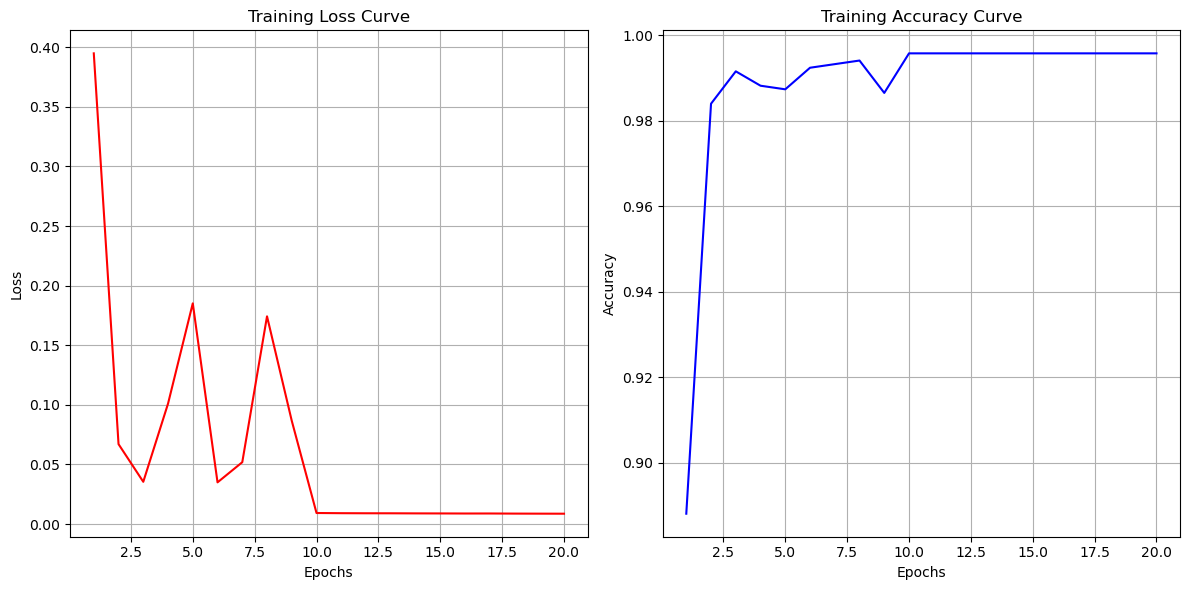

Test Accuracy: 0.9564


In [13]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

X_train_tensor = torch.tensor(X_train_vectors, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectors, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, train_labels_tensor)
test_dataset = TensorDataset(X_test_tensor, test_labels_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class TextClassificationNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TextClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  
        self.fc2 = nn.Linear(128, 64)         
        self.fc3 = nn.Linear(64, output_dim)  
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x  

input_dim = X_train_vectors.shape[1]  
output_dim = len(np.unique(train_labels))  

model = TextClassificationNN(input_dim=input_dim, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []
train_accuracies = []

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

plt.figure(figsize=(12, 6))

#  training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)

# training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.grid(True)

plt.tight_layout()
plt.show()

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")


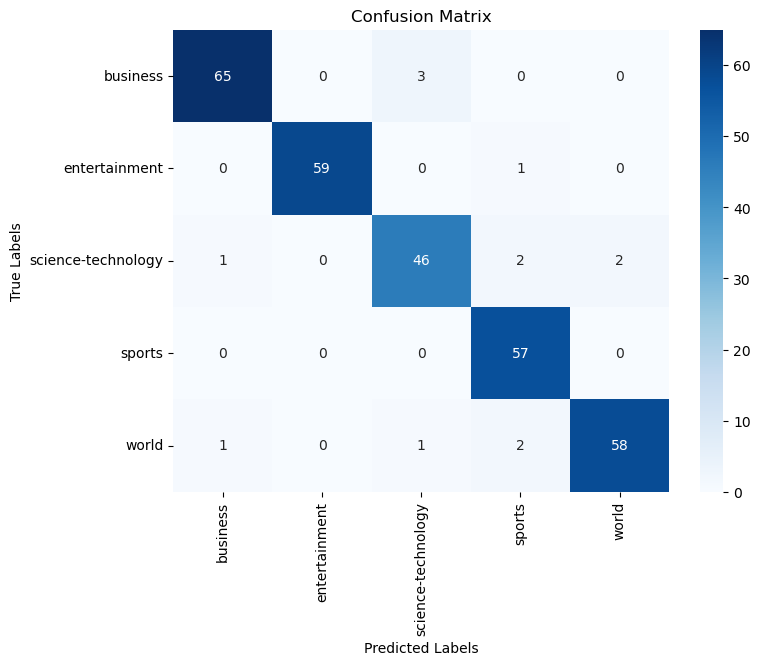

Test Accuracy: 0.9564
Test Precision: 0.9571
Test Recall: 0.9564
Test F1 Score: 0.9563


In [17]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions on the test set
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())  
        test_labels_list.extend(labels.cpu().numpy())  

accuracy = accuracy_score(test_labels_list, test_preds)
f1 = f1_score(test_labels_list, test_preds, average='weighted') 
recall = recall_score(test_labels_list, test_preds, average='weighted')  
precision = precision_score(test_labels_list, test_preds, average='weighted')  
cm = confusion_matrix(test_labels_list, test_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Display the metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
